###对数据进行基本的探索
###返回缺失值个数以及最大最小值

In [18]:
import pandas as pd
datafile= 'CustomerClustering/data/air_data.csv' #航空原始数据,第一行为属性标签
resultfile = 'CustomerClustering/tmp/explore.xls' #数据探索结果表

data = pd.read_csv(datafile, encoding = 'utf-8') #读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
data.head()

explore = data.describe(percentiles = [], include = 'all').T #包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）；T是转置，转置后更方便查阅
explore['null'] = len(data)-explore['count'] #describe()函数自动计算非空值数，需要手动计算空值数

explore = explore[['null', 'max', 'min']]
explore.columns = [u'空值数', u'最大值', u'最小值'] #表头重命名
'''这里只选取部分探索结果。
describe()函数自动计算的字段有count（非空值数）、unique（唯一值数）、top（频数最高者）、freq（最高频数）、mean（平均值）、std（方差）、min（最小值）、50%（中位数）、max（最大值）'''

explore.to_excel(resultfile) #导出结果

In [15]:
explore.head()

,空值数,最大值,最小值
MEMBER_NO,0,62988,1
FFP_DATE,0,NaN,NaN
FIRST_FLIGHT_DATE,0,NaN,NaN
GENDER,3,NaN,NaN
FFP_TIER,0,6,4


#数据清洗，过滤掉不符合规则的数据

In [26]:
#-*- coding: utf-8 -*-
import pandas as pd
datafile= 'CustomerClustering/data/air_data.csv' #航空原始数据,第一行为属性标签
cleanedfile = 'CustomerClustering/tmp/air_data_cleaned.csv' #数据清洗后保存的文件

data = pd.read_csv(datafile,encoding='utf-8') #读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
print ("原始数据条数： ", len(data))

data = data[data['SUM_YR_1'].notnull() & data['SUM_YR_2'].notnull()] #票价非空值才保留

#只保留票价非零的，或者平均折扣率与总飞行公里数同时为0的记录。
index1 = data['SUM_YR_1'] != 0
index2 = data['SUM_YR_2'] != 0
index3 = (data['SEG_KM_SUM'] == 0) & (data['avg_discount'] == 0) #该规则是“与”
data = data[index1 | index2 | index3] #该规则是“或”


# 原始数据中属性太多，选择与LRFMC指标相关的6个属性
data = data[['FFP_DATE','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','LOAD_TIME','avg_discount']]
data.to_csv(cleanedfile,encoding='utf-8',index=False) #导出结果
print ("清洗后数据条数： ", len(data))
data.head()

原始数据条数：  62988
清洗后数据条数：  62044


,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,LOAD_TIME,avg_discount
0,2006/11/02,1,210,580717,2014/03/31,0.961639
1,2007/02/19,7,140,293678,2014/03/31,1.252314
2,2007/02/01,11,135,283712,2014/03/31,1.254676
3,2008/08/22,97,23,281336,2014/03/31,1.090870
4,2009/04/10,5,152,309928,2014/03/31,0.970658


#数据可视化

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns#数据可视化

datafile= 'CustomerClustering/data/air_data.csv'
data = pd.read_csv(datafile,encoding='utf-8')
data = data[data['SUM_YR_1'].notnull() & data['SUM_YR_2'].notnull()]
index1 = data['SUM_YR_1'] != 0
index2 = data['SUM_YR_2'] != 0
index3 = (data['SEG_KM_SUM'] == 0) & (data['avg_discount'] == 0)
data = data[index1 | index2 | index3]

def feature_box(feature, data):#绘制特征的箱型图
    print(data[feature].describe())
    data[feature].plot.box(title = feature)
    plt.grid(linestyle="--", alpha=0.3)
    plt.rcParams['font.sans-serif']=['SimHei','Times New Roman'] # 用来正常显示中文标签
    plt.show()

def feature_bar(feature, data):#绘制特征的直方图
    print(data[feature].describe())
    feat_data = data[feature].value_counts()
    sns.barplot(feat_data.index.values, feat_data.values)
    plt.grid(linestyle="--", alpha=0.3)
    plt.rcParams['font.sans-serif']=['SimHei','Times New Roman'] # 用来正常显示中文标签
    plt.show()


count    61632.000000
mean        42.504300
std          9.885877
min          6.000000
25%         35.000000
50%         41.000000
75%         48.000000
max        110.000000
Name: AGE, dtype: float64
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


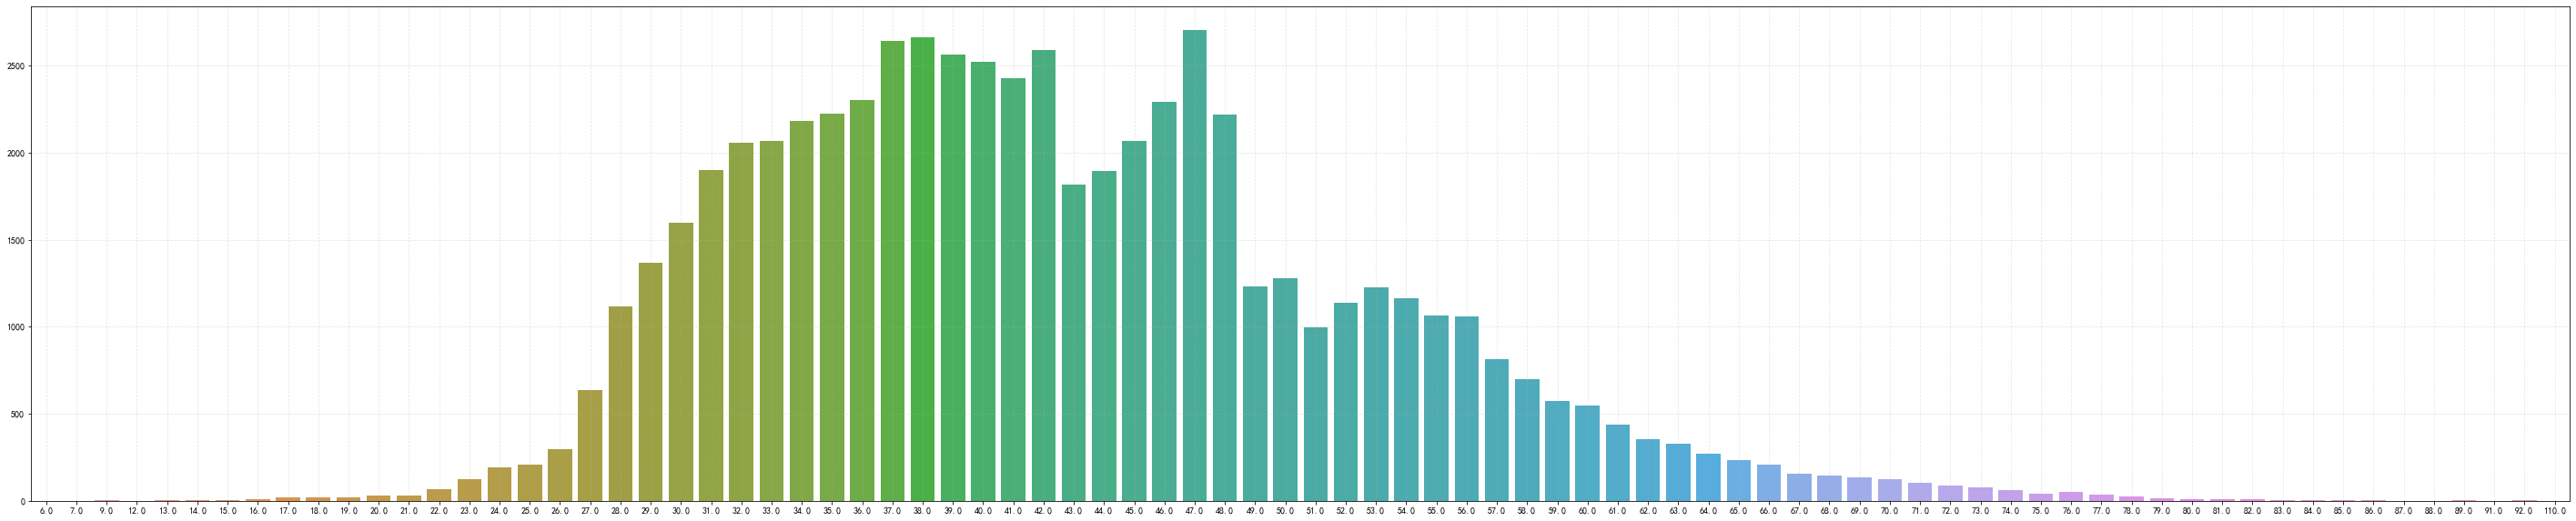

In [204]:
plt.figure(figsize=(50,10))
feature_bar('AGE', data)#会员年龄

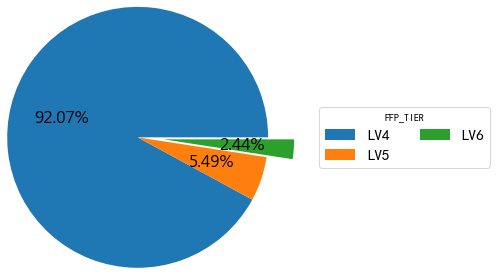

<Figure size 1440x720 with 0 Axes>

In [251]:
#会员卡级别
feat_data = data['FFP_TIER'].value_counts()
txt = "LV{}"
label = [txt.format(feat_data.index[0]),txt.format(feat_data.index[1]),txt.format(feat_data.index[2])]
patches, texts, autotexts  = plt.pie(feat_data,autopct='%1.2f%%',explode=[0,0,0.3],radius=1.5,textprops={'color':'black',#文本颜色
                   'fontsize':16,#文本大小
                   'fontfamily':'Microsoft JhengHei',#设置微软雅黑字体
                  })
plt.legend(patches, label,#添加图例
          title="FFP_TIER",
          loc="center left",
          fontsize=15,
          bbox_to_anchor=(1.3, 0, 0.5, 1),
          ncol=2#控制图例中按照两列显示，默认为一列显示，
          )
plt.figure(figsize=(20,10))
plt.show()

count    62044.000000
mean        11.971359
std         14.110619
min          2.000000
25%          3.000000
50%          7.000000
75%         15.000000
max        213.000000
Name: FLIGHT_COUNT, dtype: float64
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


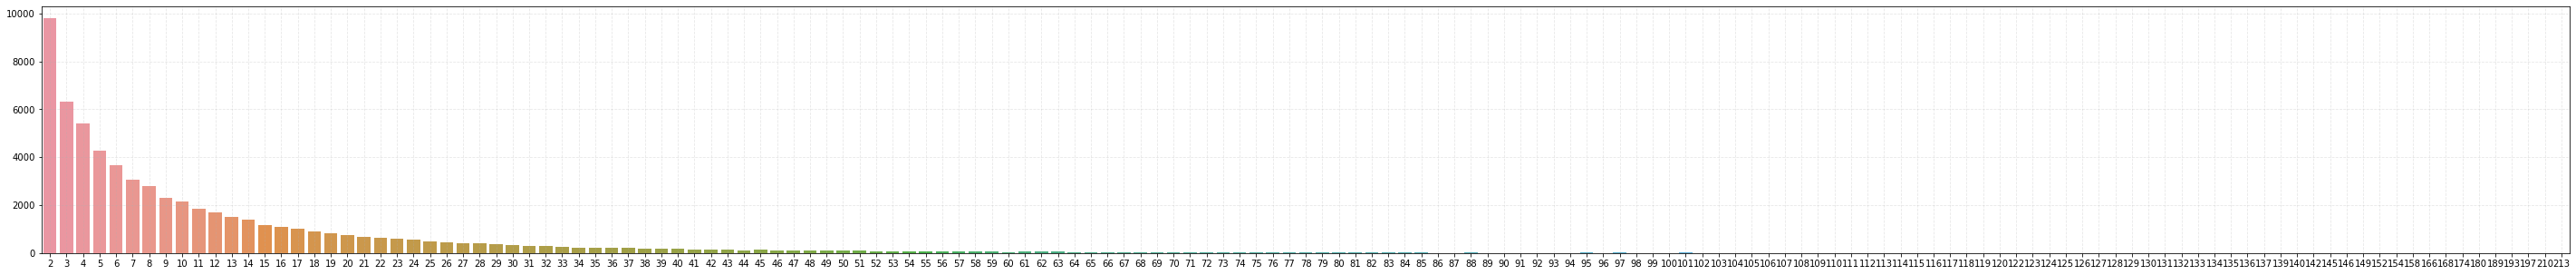

In [191]:
plt.figure(figsize=(50,5))
feature_bar('FLIGHT_COUNT', data)#飞行次数

count    62044.000000
mean         0.323480
std          1.141658
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         46.000000
Name: EXCHANGE_COUNT, dtype: float64
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


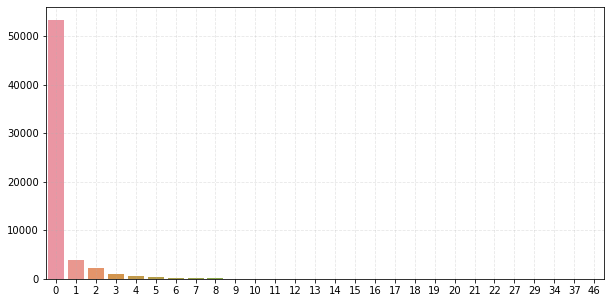

0     53349
1      3942
2      2263
3      1065
4       591
5       309
6       186
7       106
8        71
9        38
10       35
11       18
12       14
13       11
14       10
15        9
17        5
18        4
20        4
27        3
16        3
22        2
46        1
37        1
19        1
34        1
21        1
29        1
Name: EXCHANGE_COUNT, dtype: int64


In [183]:
plt.figure(figsize=(10,5))
feature_bar('EXCHANGE_COUNT', data)#兑换次数
print(data['EXCHANGE_COUNT'].value_counts())

[17433  7993  4642  4061  2400  1792  1421  1369  1184  1093]


<BarContainer object of 10 artists>

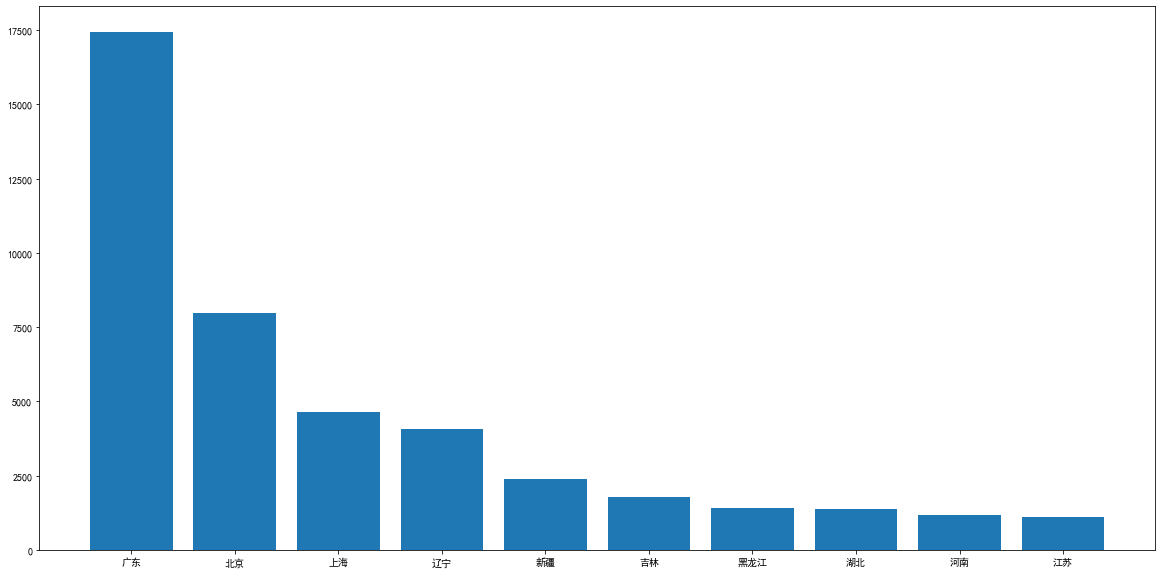

In [207]:
feat_data = data['WORK_PROVINCE'].value_counts()#会员人数前十的工作地省份
province = feat_data[feat_data>100]
province = province[0:10]
print (province.values)
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei','Times New Roman'] # 用来正常显示中文标签
plt.bar(province.index.values, province.values, label='Province', lw=1)

count    62044.000000
mean         0.722180
std          0.184833
min          0.136017
25%          0.613085
50%          0.712162
75%          0.809293
max          1.500000
Name: avg_discount, dtype: float64


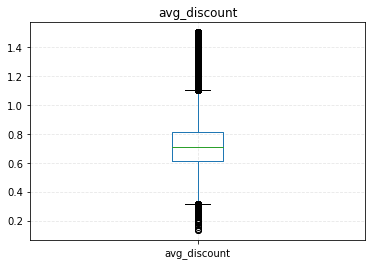

In [81]:
feature_box("avg_discount", data)

count     62044.000000
mean      12929.561682
std       17664.800018
min         212.800000
25%        3307.700000
50%        7120.090000
75%       15496.920000
max      558440.140000
Name: WEIGHTED_SEG_KM, dtype: float64


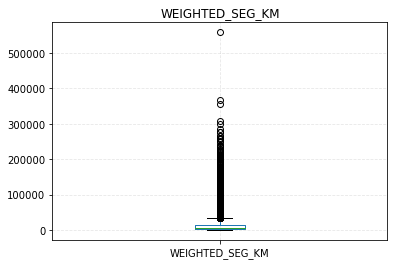

In [142]:
feature_box("WEIGHTED_SEG_KM", data)

count    62044.000000
mean       269.732093
std       1657.846655
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      74460.000000
Name: EP_SUM, dtype: float64


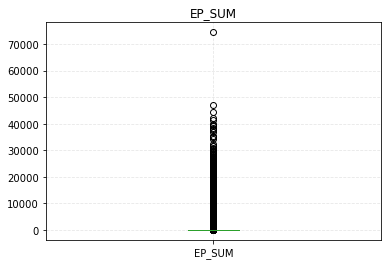

In [143]:
feature_box("EP_SUM", data)

#标准差标准化

In [27]:
import pandas as pd
import numpy as np

datafile= 'CustomerClustering/data/air_data_cleaned.csv' #航空原始数据,第一行为属性标签
normdfile = 'CustomerClustering/data/air_data_normd.csv' #数据归一化后保存的文件
#读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
data = pd.read_csv(datafile,encoding='utf-8')
data[u'LOAD_TIME'] = pd.to_datetime(data[u'LOAD_TIME'])
data[u'FFP_DATE'] = pd.to_datetime(data[u'FFP_DATE'])
#将时间差数据转换为月为单位，默认是天days
data['L'] = (data[u'LOAD_TIME'] - data[u'FFP_DATE']) / np.timedelta64(1, 'M')
data['R'] = data['LAST_TO_END']
data['F'] = data['FLIGHT_COUNT']
data['M'] = data['SEG_KM_SUM']
data['C'] = data['avg_discount']
#原始数据中属性太多，选择与LRFMC指标相关的5个属性进行标准化处理
data = data[['L','R','F','M','C']]
#z-score标准化处理
data = (data - data.mean(axis = 0)) / (data.std(axis = 0))
data.columns = ['Z'+i for i in data.columns] #表头重命名
data.to_csv(normdfile,encoding='utf-8',index=False) #导出结果
data.head()

,ZL,ZR,ZF,ZM,ZC
0,1.435707,-0.944948,14.034016,26.761154,1.295540
1,1.307152,-0.911894,9.073213,13.126864,2.868176
2,1.328381,-0.889859,8.718869,12.653481,2.880950
3,0.658476,-0.416098,0.781585,12.540622,1.994714
4,0.386032,-0.922912,9.923636,13.898736,1.344335
